In [6]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from utils.network import *
from utils.create_data import *
from utils.data import *
from utils.metrics import plot_tsne
import random

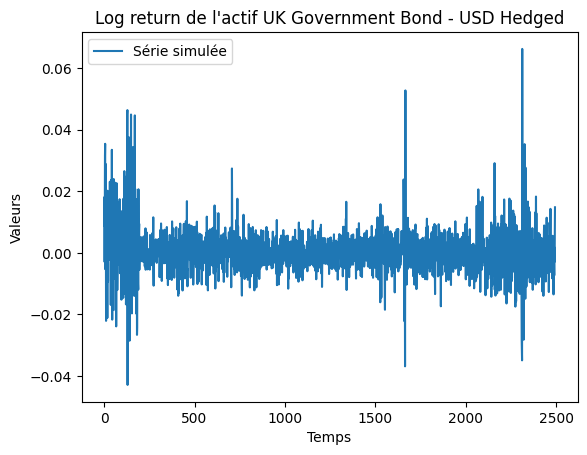

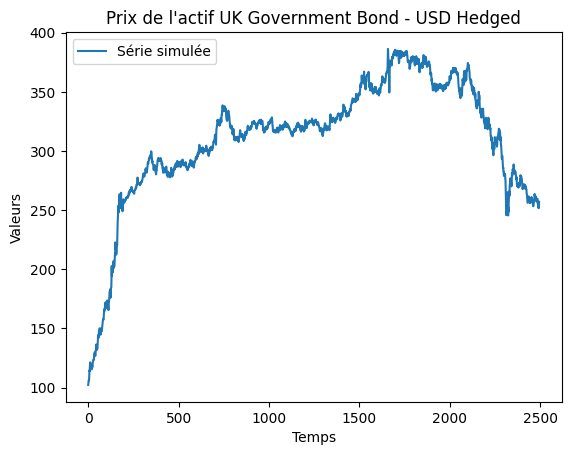

In [7]:
df = pd.read_csv('./data/GANData.csv')
actif = "UK Government Bond - USD Hedged"
sdf = df[df['ASSETNAME']==actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
simple_plot(y[:], f"Log return de l'actif {actif}")
simple_plot(true_y[:], f"Prix de l'actif {actif}")

In [8]:
from utils.network import *

In [9]:
import torch
import torch.nn as nn

# On définit un générateur de GAN "basique"
class Generator(nn.Module):
    def __init__(self, latent_dim, ts_dim, condition):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, ts_dim-condition),
            #nn.Tanh() 
        )

    def forward(self, x):
        return self.model(x)

# Définir le discriminateur
class Discriminator(nn.Module):
    def __init__(self, ts_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(ts_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Pour obtenir une probabilité entre 0 et 1
        )

    def forward(self, x):
        return self.model(x)

In [10]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 100 # Dimension de sortie
conditional = 20 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)#, dropout_prob=0.2, hidden = 64)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 200
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3)
train.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  56272


  0%|          | 0/200 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
                                                                                               

Arret préliminaire, aucune amélioration du modèle depuis 10 epochs


In [11]:
from utils.network import generate_fake_scenario

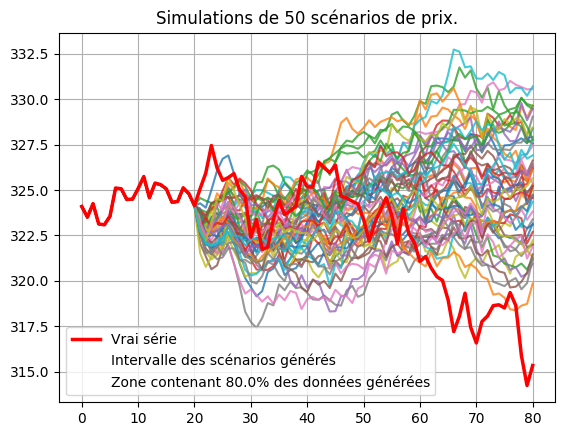

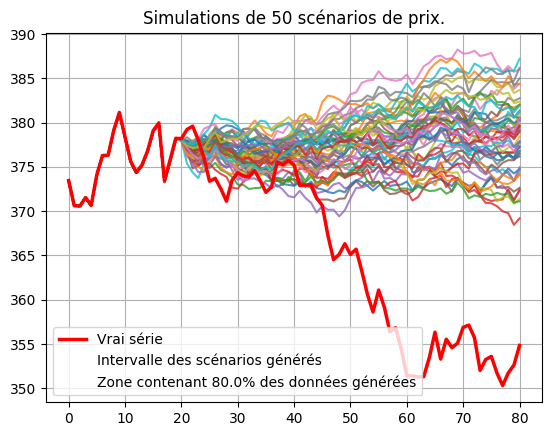

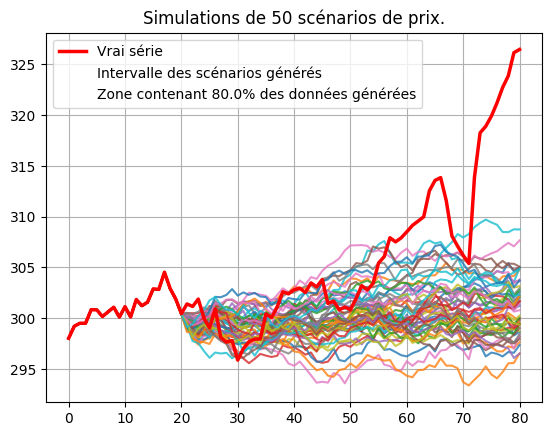

In [22]:
for i in range(3):
    start = random.randint(200,2000)
    generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =50, reducer=30,j=0.8, alphas=[0.8,0,0], count_error=False)

On voit que tout les scénarios générés ont la même allure, c'est le problème de mode collapse. En affichant seulement les log return générés, on voit bien que les scénarios générés manquent beaucoup de diversité.

862


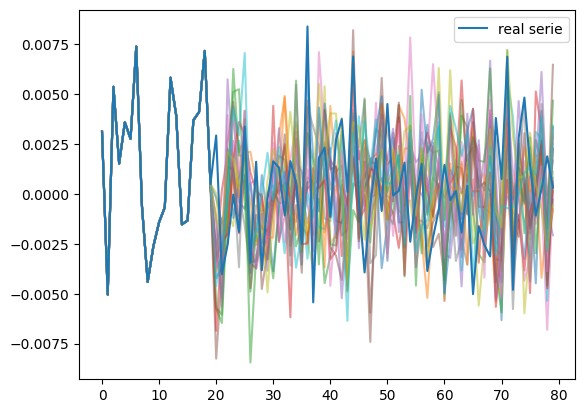

In [21]:
def show_generations(num, train, amplifier=1, reducer=4, show_real=True, alpha=0.3):
    start = random.randint(200,2000)
    amplifier = 1
    noise = torch.randn((num, 1, train.latent_dim)) * amplifier
    real_samples = torch.from_numpy(y[start:start+train.conditional])
    noise[:, :, :train.conditional] = real_samples
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    noise = noise.to(device)
    v = train.G(noise) / reducer
    v[:, :, :train.conditional] = real_samples
    v = np.array(v.float().cpu().detach()[:, 0,  :])
    print(start)
    for ar in v:
        plt.plot(ar, alpha=alpha)
    if show_real:
        plt.plot(y[start:start+train.ts_dim-train.conditional], label='real serie')
    plt.legend()
show_generations(20,train, reducer=20, alpha=0.5)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.040896
[t-SNE] KL divergence after 50 iterations with early exaggeration: 72.133636
[t-SNE] KL divergence after 300 iterations: 1.673850


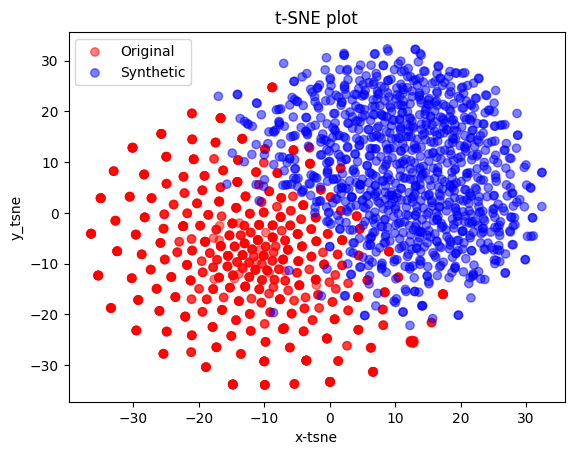

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2020 samples in 0.001s...
[t-SNE] Computed neighbors for 2020 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2020
[t-SNE] Computed conditional probabilities for sample 2000 / 2020
[t-SNE] Computed conditional probabilities for sample 2020 / 2020
[t-SNE] Mean sigma: 0.041100
[t-SNE] KL divergence after 100 iterations with early exaggeration: 72.282539
[t-SNE] KL divergence after 300 iterations: 1.813114


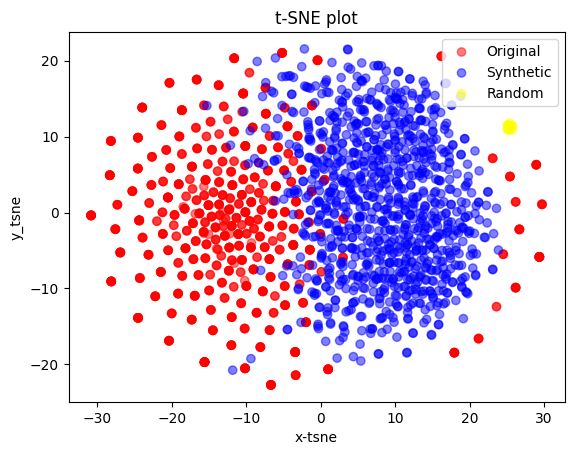

In [25]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=1000, conditional= train.conditional, use_cuda=train.use_cuda, data = train.data)
fake = fake
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=False)
plot_tsne(real_array,fake_array, random=True)

Une première méthode simple pour éviter l'overfitting est de rajouter un paramètre de dropout

In [26]:
import torch
import torch.nn as nn

# On rajoute le dropout pour éviter l'overfitting
class Generator(nn.Module):
    def __init__(self, latent_dim, ts_dim, condition, dropout_rate=0.5):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Ajout de la couche Dropout
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Ajout de la couche Dropout
            nn.Linear(256, ts_dim - condition),
            #nn.Tanh()  
        )

    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self, ts_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(ts_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        return self.model(x)


In [27]:
generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)#, dropout_prob=0.2, hidden = 64)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3)
train.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  56272


  0%|          | 0/200 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Arret préliminaire, aucune amélioration du modèle depuis 10 epochs


1088


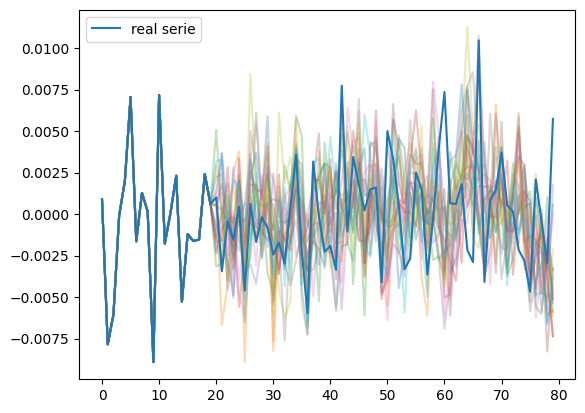

In [35]:
show_generations(20,train, reducer=18)

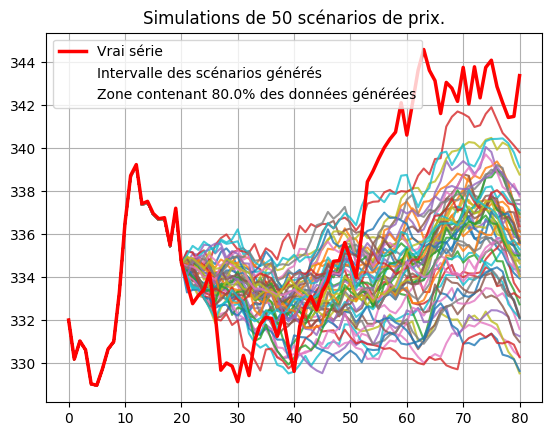

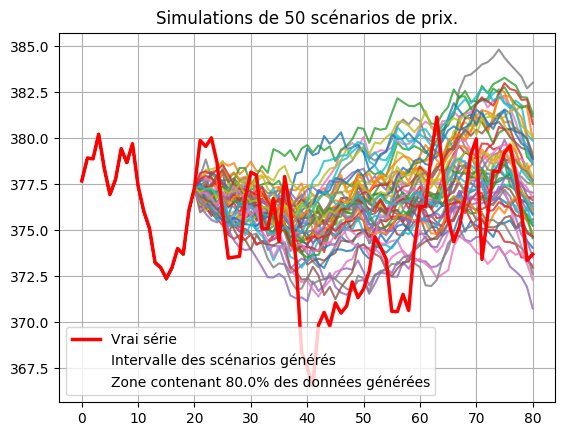

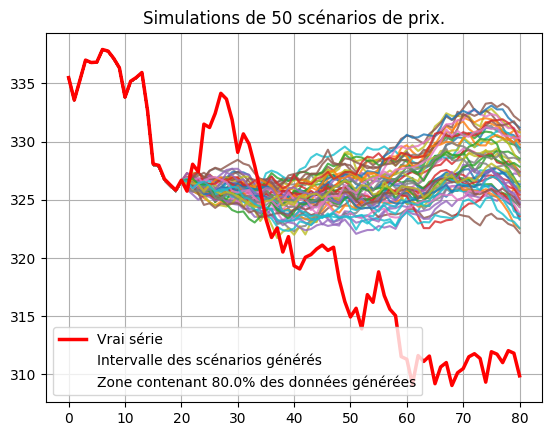

In [36]:
for i in range(3):
    start = random.randint(200,2000)
    generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =50, reducer=40,j=0.8, alphas=[0.8,0,0], count_error=False)

Le résultat est déjà plus satisfaisant

In [ ]:
from utils.metrics import evaluate_fake_scenario

Nombre d'erreur moyenne pour 101 scénarios : 0.725/40: 100%|██████████| 100/100 [07:28<00:00,  4.48s/it]


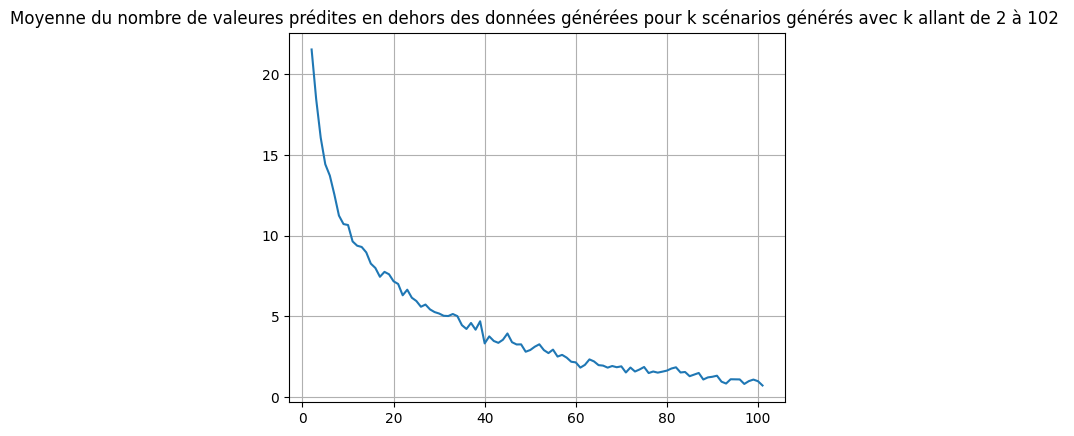

In [ ]:
list_val=[]
pb = trange(100)
for k in pb:
    score = evaluate_fake_scenario(y[200:],true_y[200:],train, amplifier = 1,num = k+2,reducer=40, n=200, no_print=True)
    pb.set_description(f"Nombre d'erreur moyenne pour {k+2} scénarios : {score}/{train.ts_dim-10}")
    list_val.append(score)
indices = range(2, len(list_val) + 2)

plt.plot(indices, list_val)
plt.title(f"Moyenne du nombre de valeures prédites en dehors des données générées pour k scénarios générés avec k allant de 2 à {len(list_val) + 2} ")
plt.grid(True)
plt.show()

In [ ]:
from utils.metrics import plot_tsne

In [37]:
np.var(real_array)

4.8410664e-05

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.041062
[t-SNE] KL divergence after 50 iterations with early exaggeration: 72.091003
[t-SNE] KL divergence after 300 iterations: 1.754439


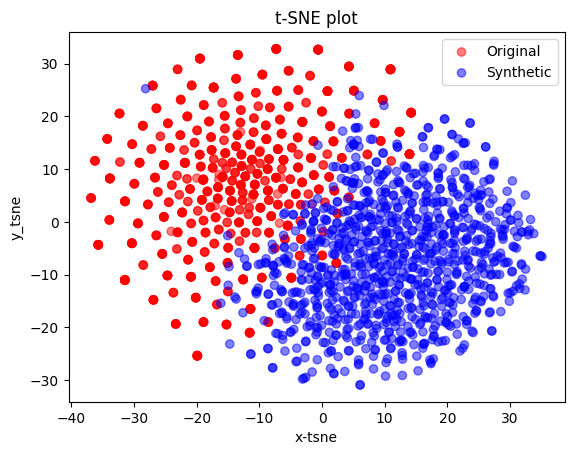

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2020 samples in 0.001s...
[t-SNE] Computed neighbors for 2020 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2020
[t-SNE] Computed conditional probabilities for sample 2000 / 2020
[t-SNE] Computed conditional probabilities for sample 2020 / 2020
[t-SNE] Mean sigma: 0.041267
[t-SNE] KL divergence after 100 iterations with early exaggeration: 72.240601
[t-SNE] KL divergence after 300 iterations: 1.827109


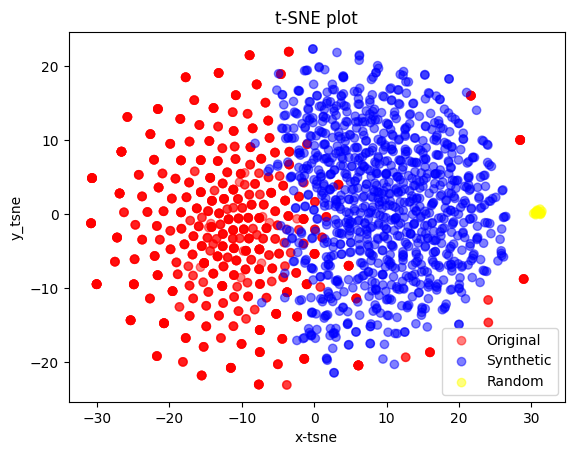

In [43]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=1000, conditional= train.conditional, use_cuda=train.use_cuda, data = train.data)
fake = fake
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=False)
plot_tsne(real_array,fake_array, random=True)

In [44]:
from utils.metrics import get_moments
mom = get_moments(train, reducer=40)
mom

100%|██████████| 1000/1000 [00:08<00:00, 124.71it/s]


{'real mean': 0.00028515476,
 'fake mean': 9.023678e-06,
 'real var': 4.7228874e-05,
 'fake var': 1.2996742e-06,
 'real skew': 0.42083445,
 'fake skew': 0.09929606,
 'real kurtosis': 3.912447,
 'fake kurtosis': 0.68777704}

In [45]:
from utils.network_lstm import LSTMGenerator, LSTMDiscriminator

In [46]:
generator = LSTMGenerator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional, dropout=0.5, hidden_dim=64)#, dropout_prob=0.2, hidden = 64)
discriminator = LSTMDiscriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train_lstm = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3, is_recc=True, limite=20)
train_lstm.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  27216


  0%|          | 0/200 [00:00<?, ?it/s]

/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
                                                                                               

Arret préliminaire, aucune amélioration du modèle depuis 20 epochs


1727


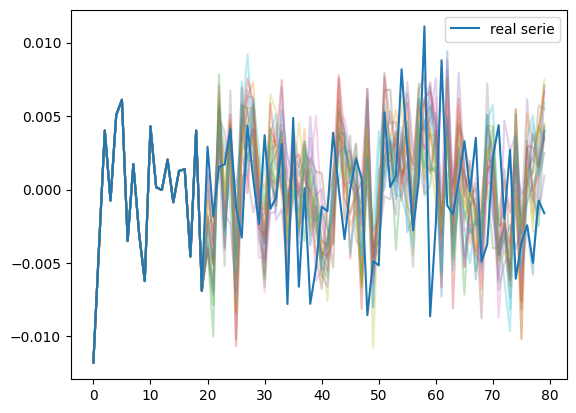

In [62]:
show_generations(train =train_lstm, num=20, reducer = 10)

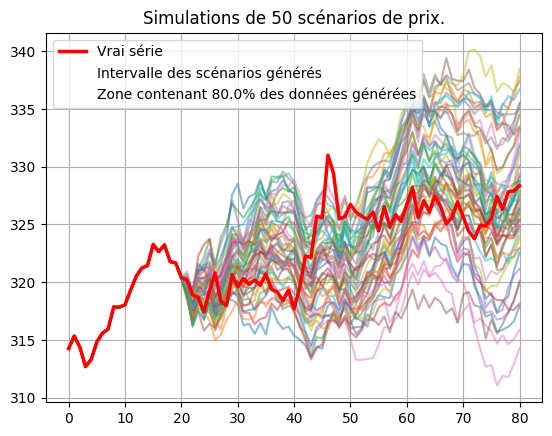

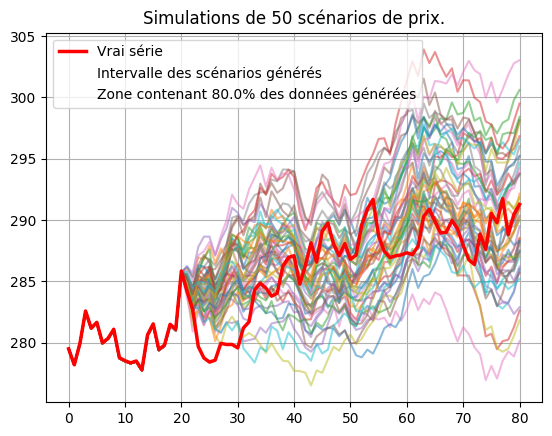

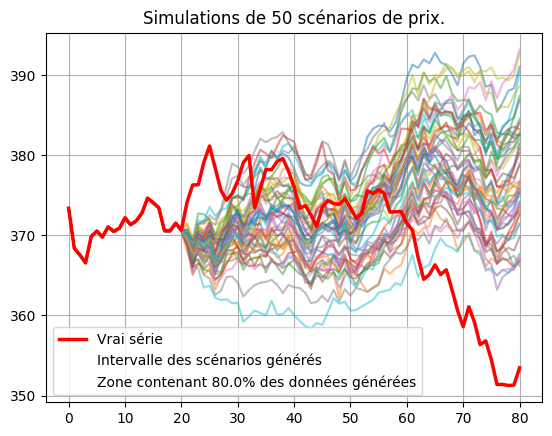

In [63]:
for i in range(3):
    start = random.randint(200,2000)
    generate_fake_scenario(y[start:],true_y[start:],train_lstm, amplifier = 1,num =50, reducer=10,j=0.8, alphas=[0.5,0,0], count_error=False)

In [49]:
from scipy.stats import kurtosis, skew
def get_moments(model,n=1000, batch_size = 50, reducer=1):
    """Calculer les estimateurs des 4 premiers moments sur les séries générées et réelles"

    Args:
        model : model de génération de données
        n (int, optional): nombre de sous échantillon. Defaults to 10000.
        batch_size (int, optional): taille des sous échantillons. Defaults to 50.


    """
    train = model
    real_mean = []
    fake_mean = []
    fake_var = []
    real_var = []
    real_skew = []
    real_kurt = []
    fake_skew = []
    fake_kurt = []
    for i in trange(n):
        fakes, real = train.data.get_samples(G=train.G, latent_dim=train.latent_dim, batch_size=batch_size, ts_dim=train.ts_dim,conditional=train.conditional,data= train.y, use_cuda=train.use_cuda)
        real_array = real.cpu().detach().numpy().reshape(batch_size,train.ts_dim)
        fake_array = fakes.cpu().detach().numpy().reshape(batch_size,train.ts_dim)/reducer
        fake_var.append(np.var(fake_array))
        real_var.append(np.var(real_array))
        fake_mean.append(np.mean(fake_array))
        real_mean.append(np.mean(real_array))
        fake_skew.append(skew(fake_array))
        real_skew.append(skew(real_array))
        fake_kurt.append(kurtosis(fake_array))
        real_kurt.append(kurtosis(real_array))
    return {"real mean":np.mean(real_mean), "fake mean": np.mean(fake_mean), "real var":np.mean(real_var), "fake var":np.mean(fake_var),"real skew": np.mean(real_skew), "fake skew": np.mean(fake_skew),
    "real kurtosis":np.mean(real_kurt), "fake kurtosis": np.mean(fake_kurt)}



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.039568
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.545357
[t-SNE] KL divergence after 300 iterations: 2.179140


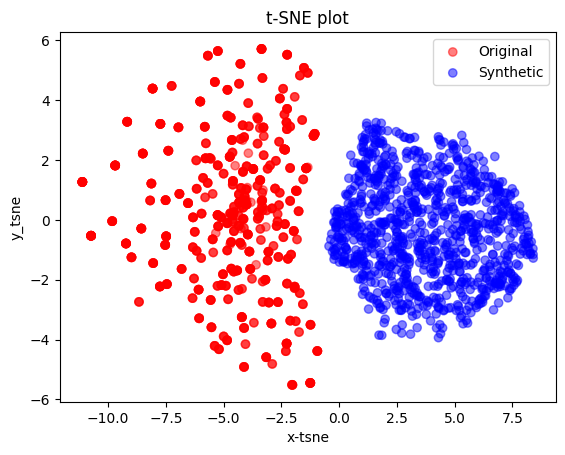

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2020 samples in 0.001s...
[t-SNE] Computed neighbors for 2020 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2020
[t-SNE] Computed conditional probabilities for sample 2000 / 2020
[t-SNE] Computed conditional probabilities for sample 2020 / 2020
[t-SNE] Mean sigma: 0.039765
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.656433
[t-SNE] KL divergence after 300 iterations: 2.159286


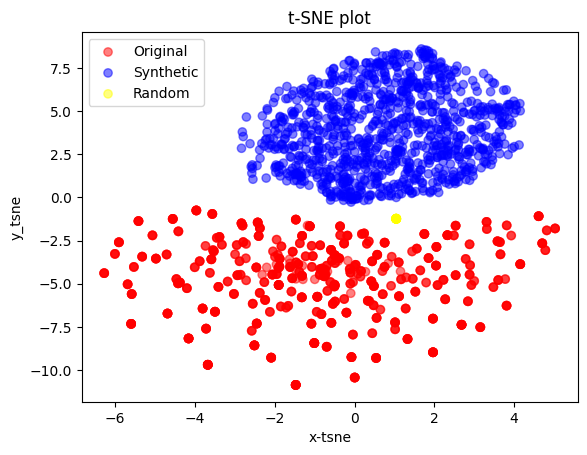

In [50]:
fake , real = train_lstm.data.get_samples(G = train_lstm.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=1000, conditional= train.conditional, use_cuda=train.use_cuda, data = train.data)
fake = fake
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=False)
plot_tsne(real_array,fake_array, random=True)

In [51]:
from utils.network import Generator, Discriminator

In [52]:
generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional, dropout_prob=0.5, hidden=128)#, dropout_prob=0.2, hidden = 64)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train_cnn = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3)
train_cnn.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  273242


  0%|          | 0/200 [00:00<?, ?it/s]

/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
                                                                                               

Arret préliminaire, aucune amélioration du modèle depuis 10 epochs


1075


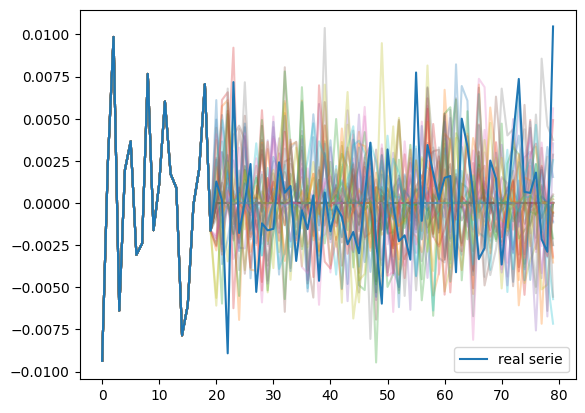

In [74]:
show_generations(train = train_cnn,num=50, reducer=8)

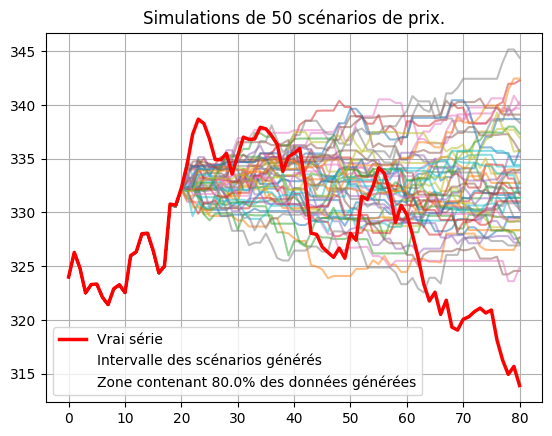

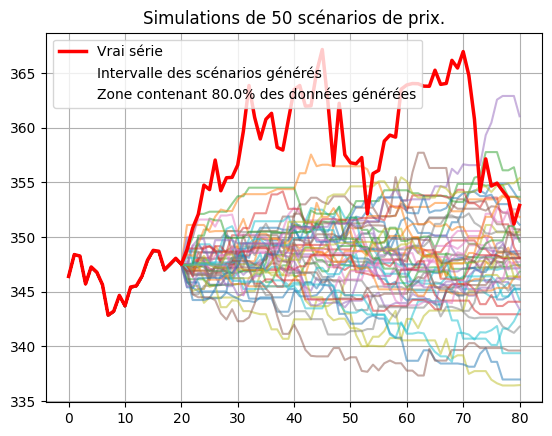

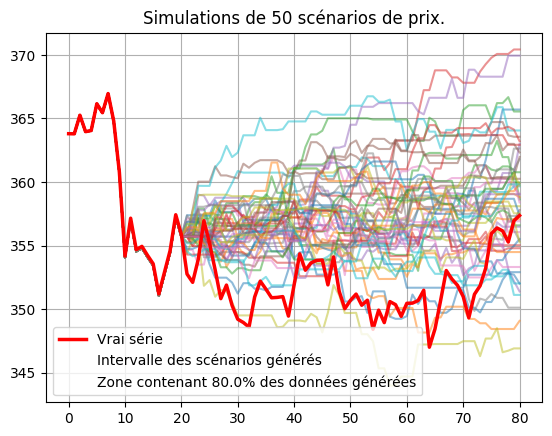

In [75]:
for i in range(3):
    start = random.randint(200,2000)
    generate_fake_scenario(y[start:],true_y[start:],train_cnn, amplifier = 1,num =50, reducer=8,j=0.8, alphas=[0.5,0,0], count_error=False)

In [55]:
from sklearn.manifold import TSNE

def plot_tsne(real_array, fake_array, random=False, num_random=20, alphas=[0.5,0.5,0.5], hyper_p={"n_components":2, "verbose":1, "perplexity":10, "n_iter":300}):
    tsne = TSNE(n_components=hyper_p["n_components"], verbose=hyper_p["verbose"], perplexity=hyper_p["perplexity"], n_iter=hyper_p["n_iter"])
    num_real = real_array.shape[0]  
    len_real = real_array.shape[2] 
    num_fake = fake_array.shape[0]
    if random:
        array_full = np.concatenate((np.squeeze(real_array), np.squeeze(fake_array), np.random.rand(num_random, len_real)), axis = 0)
        colors = ["red" for i in range(num_real)] + ["blue" for i in range(num_fake)] + ["yellow" for i in range(num_random)] 
    else:
        array_full = np.concatenate((np.squeeze(real_array), np.squeeze(fake_array)), axis = 0)
        colors = ["red" for i in range(num_real)] + ["blue" for i in range(num_fake)] 
    tsne_results = tsne.fit_transform(array_full)
    #colors = ["red" for i in range(num_real)] + ["blue" for i in range(num_fake)] + ["yellow" for i in range(num_real)] 
    f, ax = plt.subplots(1)
        
    plt.scatter(tsne_results[:num_real,0], tsne_results[:num_real,1], 
                c = colors[:num_real], alpha = alphas[0], label = "Original")
    plt.scatter(tsne_results[num_real:num_real + num_fake,0], tsne_results[num_real: num_real + num_fake,1], 
                c = colors[num_real:num_real + num_fake], alpha = alphas[1], label = "Synthetic")
    if random:
        plt.scatter(tsne_results[num_real+num_fake:,0], tsne_results[num_real*2:,1], 
                c = colors[num_real+num_fake:], alpha = alphas[2], label = "Random")

    ax.legend()
        
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

In [96]:
len(y)/100

24.94

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.436234
[t-SNE] KL divergence after 300 iterations: 2.610568


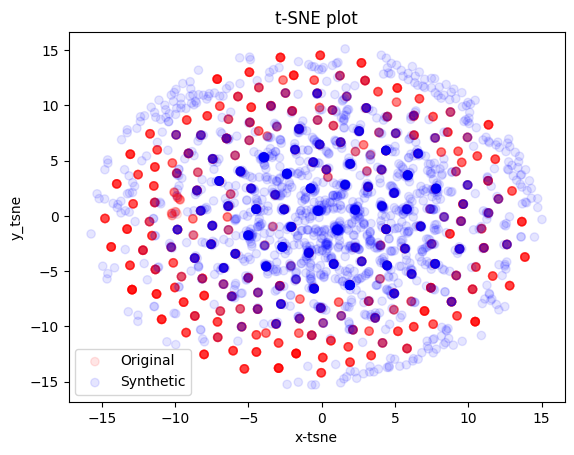

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5020 samples in 0.001s...
[t-SNE] Computed neighbors for 5020 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5020
[t-SNE] Computed conditional probabilities for sample 2000 / 5020
[t-SNE] Computed conditional probabilities for sample 3000 / 5020
[t-SNE] Computed conditional probabilities for sample 4000 / 5020
[t-SNE] Computed conditional probabilities for sample 5000 / 5020
[t-SNE] Computed conditional probabilities for sample 5020 / 5020
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.772537
[t-SNE] KL divergence after 300 iterations: 2.690807


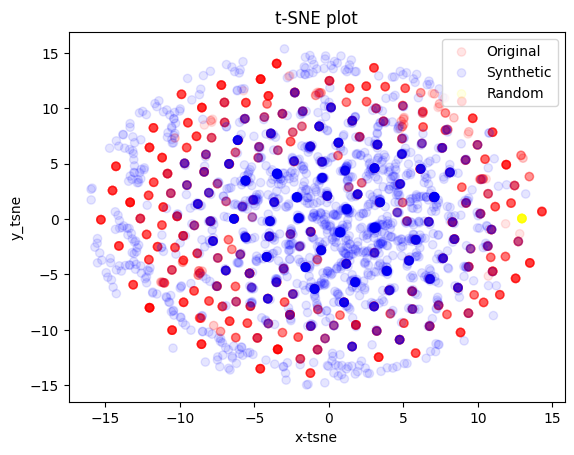

In [99]:
fake , real = train_cnn.data.get_samples(G = train_cnn.G, latent_dim = train_cnn.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=2500, conditional= train.conditional, use_cuda=train.use_cuda, data = train.data)
fake = fake /1.5
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=False, alphas=[0.1,0.1, 1])
plot_tsne(real_array,fake_array, random=True, alphas=[0.1,0.1,0.1])

In [83]:
Moments_base = get_moments(train)
Moments_lstm = get_moments(train_lstm)
Moments_cnn = get_moments(train_cnn)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:14<00:00, 67.20it/s]


In [84]:
diff_moments_base = {}
for key in Moments_base.keys():
    if key.startswith('real'):
        diff_moments_base[f'diff {key[5:]}'] = abs(Moments_base[key]-Moments_base[f'fake {key[5:]}'])
diff_moments_lstm = {}
for key in Moments_lstm.keys():
    if key.startswith('real'):
        diff_moments_lstm[f'diff {key[5:]}'] = abs(Moments_lstm[key]-Moments_lstm[f'fake {key[5:]}'])
diff_moments_cnn = {}
for key in Moments_cnn.keys():
    if key.startswith('real'):
        diff_moments_cnn[f'diff {key[5:]}'] = abs(Moments_cnn[key]-Moments_cnn[f'fake {key[5:]}'])


In [85]:
df = pd.DataFrame([diff_moments_base, diff_moments_lstm, diff_moments_cnn], index=['Base GAN', 'LSTM GAN', 'DC-GAN'])
def highlight_min(s):
    is_min = s == s.min()
    return ['color: red' if v else '' for v in is_min]
df = df.style.apply(highlight_min)
df

In [100]:
from utils.network import generate_long_range

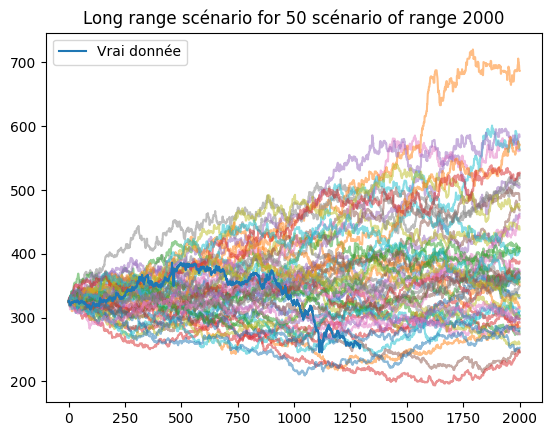

In [123]:
start = random.randint(500,2500)
start = 1200
v, fake_lines = generate_long_range(y[start:],true_y[start:],train_cnn,length=2500, n=50,reducer=3, show_real=True ,amplifier=1)

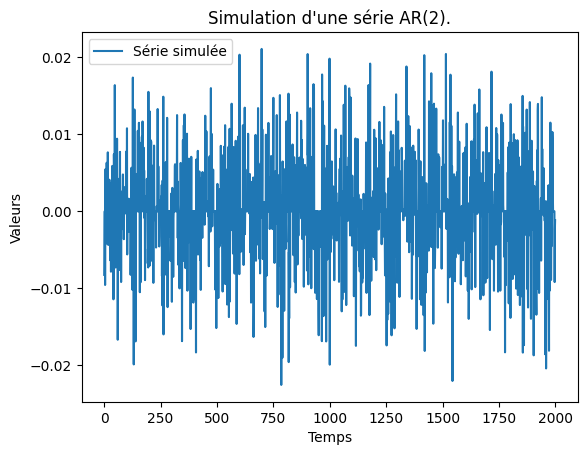

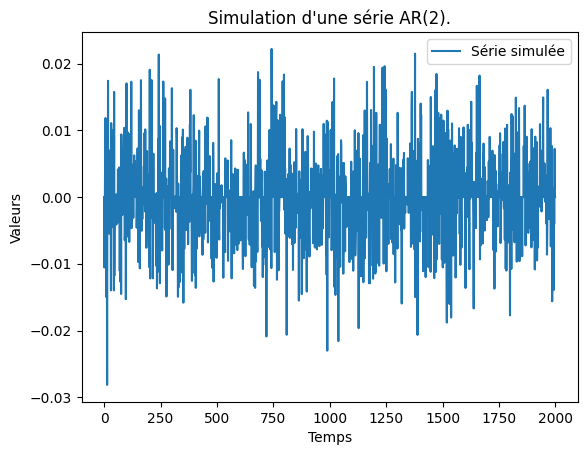

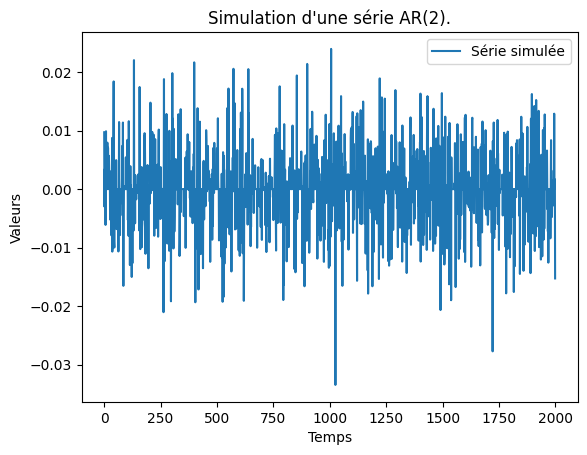

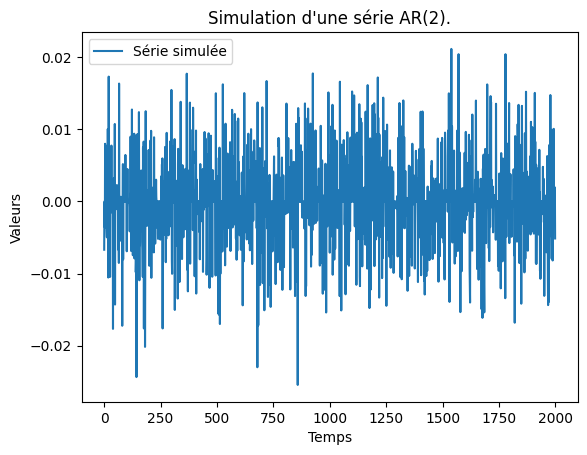

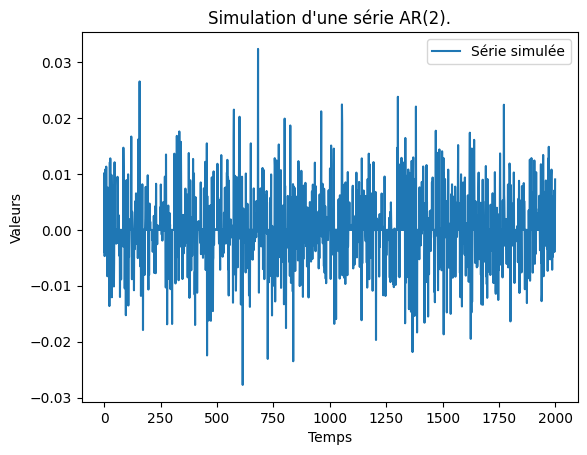

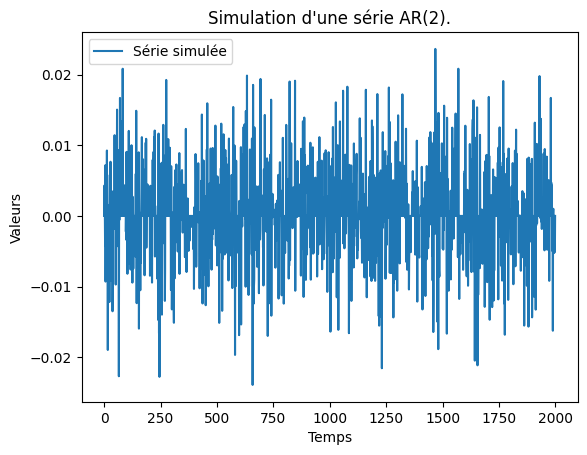

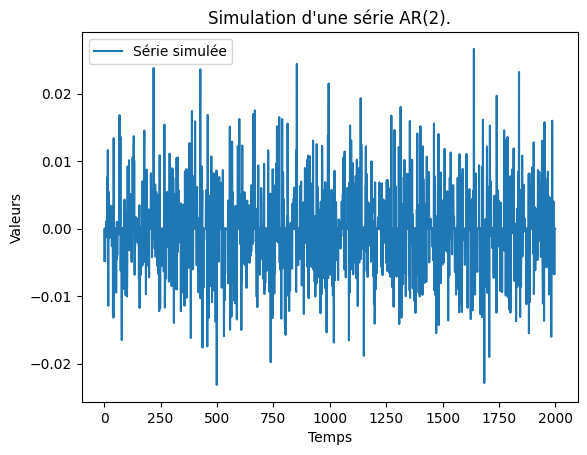

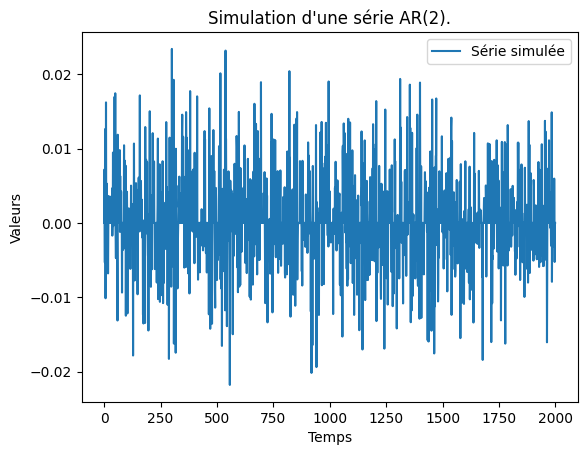

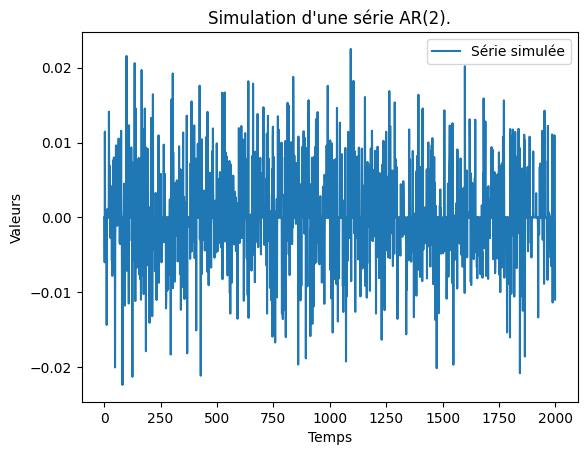

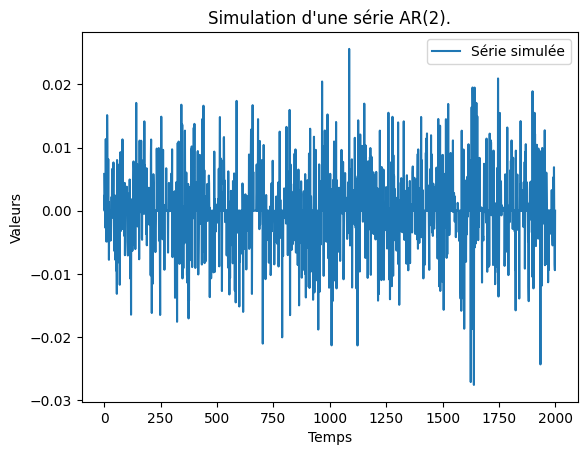

In [124]:
for i in range(10):
    x_hat = np.log(fake_lines[i,1:] / fake_lines[i,:-1])
    simple_plot(x_hat)

In [113]:
fake_lines[0]

array([325.71966321, 325.71966321, 325.71966321, ..., 401.44562687,
       403.34423918, 396.97542133])

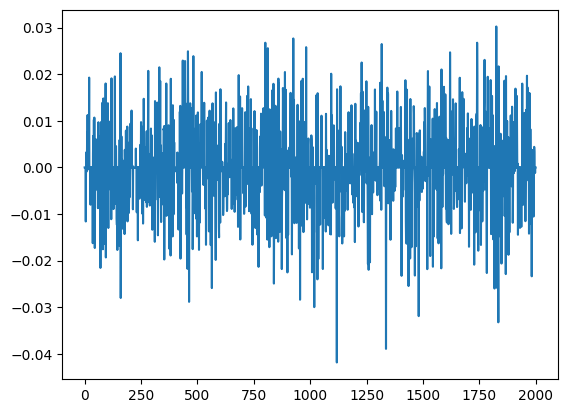

In [114]:
plt.plot(x_hat)

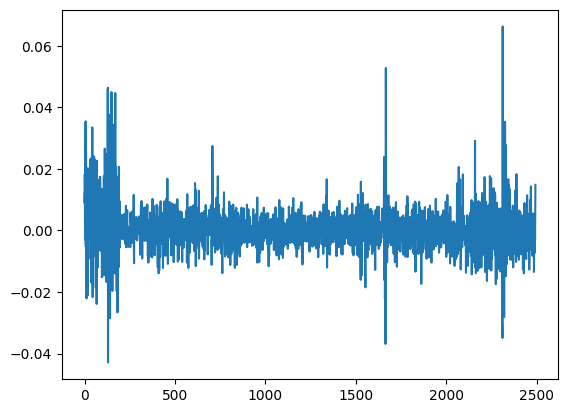

In [115]:
plt.plot(y)